# Pylops - Marchenko redatuming with missing sources

### Author: M.Ravasi

In this notebook we consider to extensions of the Marchenko inversion in the presence of missing sources

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import bicgstab, lsqr
from scipy.signal import convolve, fftconvolve, filtfilt, hilbert

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

import MarchenkoFunctions as MF

## Inputs

Input parameters 

In [2]:
path0='./datasets_new/'

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nfft = 2 ** 11      # number of fft samples
nstaper = 11        # source/receiver taper lenght
n_iter = 200        # iterations
    
jr = 3              # subsampling in r
jt = 5

Load input

Read and visualize geometry

In [3]:
# Receivers
r = np.loadtxt(path0 + 'r.dat', delimiter=',')
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = np.loadtxt(path0 + 's.dat', delimiter=',')
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = [1200, 1240]

# Geometry
nz = 401
oz = 0
dz = 4
z = np.arange(oz, oz + nz*dz, dz)

nx=751
ox=0
dx=4
x = np.arange(ox, ox + nx*dx, dx)

Read data

In [4]:
# time axis
ot=0
nt=1081
dt=0.0025
t = np.arange(ot,ot+nt*dt,dt)
t2 = np.concatenate([-t[::-1], t[1:]])
nt2 = len(t2)

# data
R=np.zeros((nt, ns, nr),'f')
for isrc in range(ns-1):
    is_ = isrc*jr
    R[:,:,isrc]=np.loadtxt(path0 + 'dat1_' + str(is_) + '.dat', delimiter=',')

R = 2 * np.swapaxes(R,0,2)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

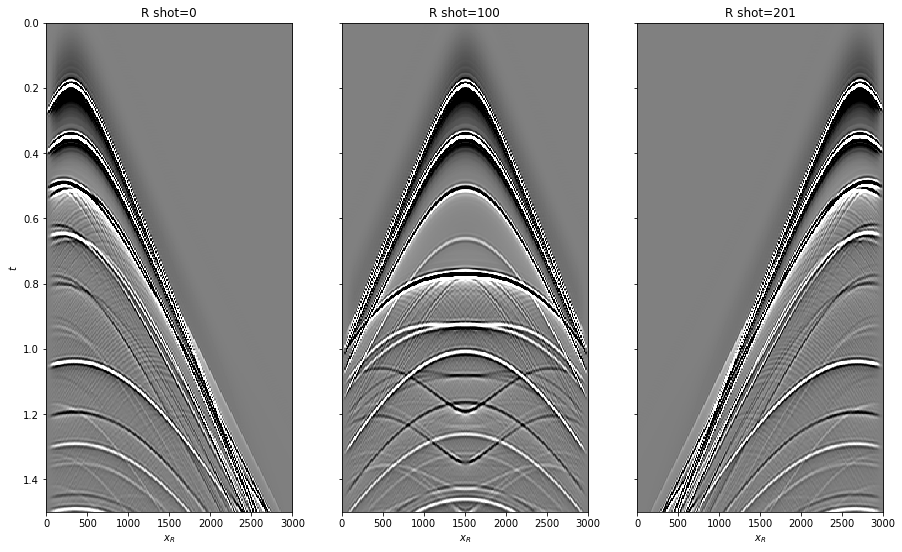

In [5]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(R[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(R[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1.5, 0);

Read wavelet and traveltime 

In [6]:
wav = np.loadtxt(path0 + 'wav.dat', delimiter=',')
    
trav_eik = np.loadtxt(path0 + 'trav.dat', delimiter=',')
trav_eik = np.reshape(trav_eik,(nz, ns, nx))

## Marchenko preparation

Create first arrival

In [7]:
# direct arrival window - traveltime
directVS = trav_eik[MF.find_closest(vs[1],z)-1,:,MF.find_closest(vs[0],x)-1]
directVS_off = directVS - toff

G0sub = directwave(wav, directVS, nt, dt, nfft=2**11)

Create window

In [8]:
# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)

Create analytical direct wave

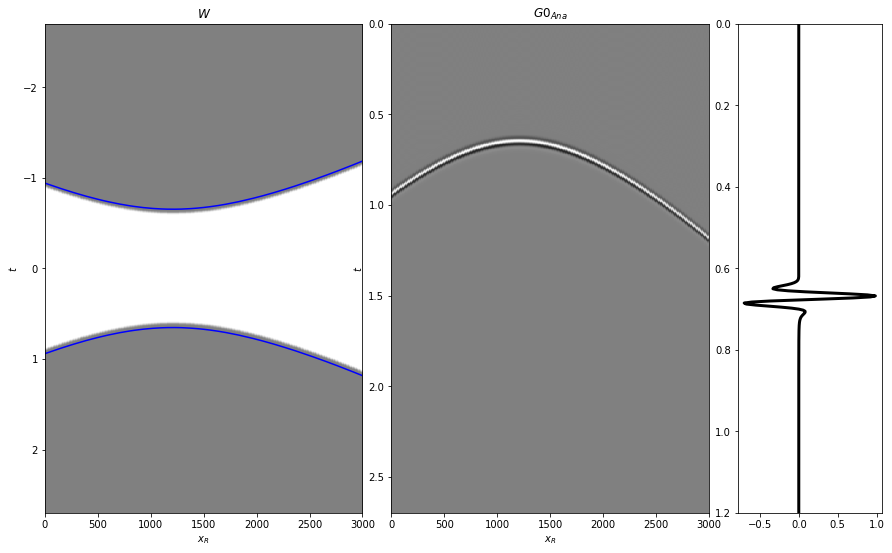

In [9]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(w.T, cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax1.plot(r[0], directVS,'b'),ax1.plot(r[0], -directVS,'b')
ax1.set_title(r'$W$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax2.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')

ax3.plot(G0sub[:, nr//2]/G0sub.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

## Marchenko with full sources

Let's start by creating benchmark responses

In [10]:
# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((ns, nr, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, s, r]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, transpose=False, dtype='complex64')
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, transpose=False, conj=True, dtype='complex64')
Rollop = Roll((2*nt-1) * ns,
              dims=(2*nt-1, ns),
              dir=0, shift=-1)
Wsop = Diagonal(w.T.flatten())
Wrop = Diagonal(w.T.flatten())
Iop = Identity(nr*(2*nt-1))

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr))))

Mop = VStack([HStack([Iop, -1*Wsop*Rop]),
              HStack([-1*Wsop*Rollop*R1op, Iop])])*BlockDiag([Wrop, Wrop])
Gop = VStack([HStack([Iop, -1*Rop]),
              HStack([-1*Rollop*R1op, Iop])])

dottest(Gop, 2*ns*(2*nt-1), 2*nr*(2*nt-1), verb=True)
dottest(Mop, 2*ns*(2*nt-1), 2*nr*(2*nt-1), verb=True);

Dot test passed, v^T(Opu)=382.880170 - u^T(Op^Tv)=382.880170
Dot test passed, v^T(Opu)=1197.304352 - u^T(Op^Tv)=1197.304352


In [11]:
p0_minus = Rop * fd_plus.flatten()
p0_minus = p0_minus.reshape((2*nt-1), ns).T

d = Wsop*Rop*fd_plus.flatten()
d = np.concatenate((d.reshape(2*nt-1, ns), np.zeros((2*nt-1, ns))))

f1_adj = Mop.H*d.flatten()
f1_inv = lsqr(Mop, d.flatten(), iter_lim=10, show=True)[0]

f1_adj = f1_adj.reshape(2*nt2, nr)
f1_inv = f1_inv.reshape(2*nt2, nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   868722 rows  and   868722 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.277e+01  5.277e+01    1.0e+00  2.0e-02
     1  0.00000e+00   2.335e+01  2.335e+01    4.4e-01  9.8e-01   1.2e+00  1.0e+00
     2  0.00000e+00   1.344e+01  1.344e+01    2.5e-01  4.0e-01   1.9e+00  2.2e+00
     3  0.00000e+00   1.056e+01  1.056e+01    2.0e-01  2.8e-01   2.3e+00  3.4e+00
     4  0.00000e+00   8.256e+00  8.256e+00    1.6e-01  2.7e-01   2.7e+00  5.1e+00
     5  0.00000e+00   6.564e+00  6.564e+00    1.2e-01  2.0e-01   3.0e+00  6.9e+00
     6  0.00000e+00   5.587e+00  5.587e+00    1.1e-01  1.7e-01   3.3e+00  8.6e+00
     7  0.00000e+00   4.669e+00  4.669e+00    8.8e-02  1.7e-01   3.6e+00  1.1e+01
     8  0.00000e+00   3.926e

In [12]:
f1_adj_tot = f1_adj + np.concatenate((np.zeros((2*nt-1, nr)),
                                      np.concatenate((np.fliplr(G0sub.T).T, 
                                                      np.zeros((nt-1, nr))), axis=0)))

f1_inv_tot = f1_inv + np.concatenate((np.zeros((2*nt-1, nr)), fd_plus))

g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*(2*nt-1), ns)
g_inv = g_inv.reshape(2*(2*nt-1), ns)

f1_adj_minus, f1_adj_plus =  f1_adj_tot[:(2*nt-1)].T, f1_adj_tot[(2*nt-1):].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:(2*nt-1)].T, f1_inv_tot[(2*nt-1):].T

g_adj_minus, g_adj_plus =  -g_adj[:(2*nt-1)].T, np.fliplr(g_adj[(2*nt-1):].T)
g_inv_minus, g_inv_plus =  -g_inv[:(2*nt-1)].T, np.fliplr(g_inv[(2*nt-1):].T)

g_inv_tot = g_inv_minus + g_inv_plus

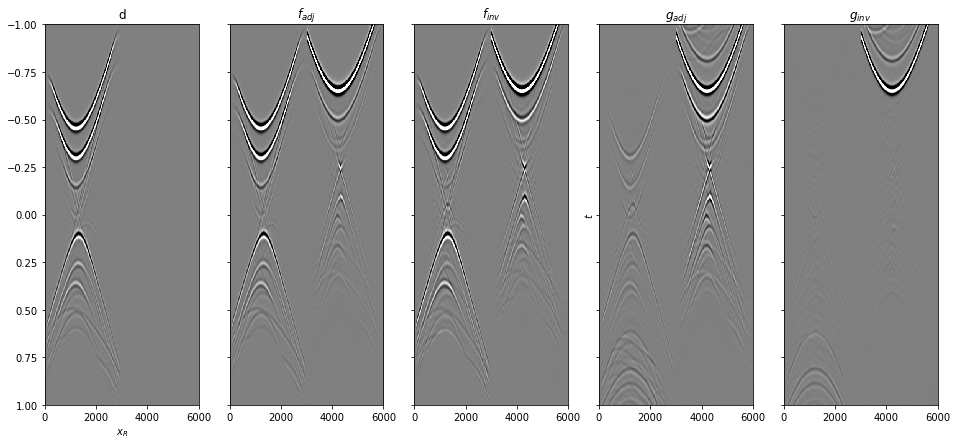

In [13]:
# Need to recreate combined data as new implementation stacks over time instead of space
d_plot = np.concatenate((d[:(2*nt-1)], d[(2*nt-1):]), axis=1).T
f1_adj_tot_plot = np.concatenate((f1_adj_tot[:(2*nt-1)], f1_adj_tot[(2*nt-1):]), axis=1).T
f1_inv_tot_plot = np.concatenate((f1_inv_tot[:(2*nt-1)], f1_inv_tot[(2*nt-1):]), axis=1).T
g_adj_plot = np.concatenate((g_adj[:(2*nt-1)], g_adj[(2*nt-1):]), axis=1).T
g_inv_plot = np.concatenate((g_inv[:(2*nt-1)], g_inv[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_S$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_adj_tot_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_tot_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(g_adj_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(g_inv_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

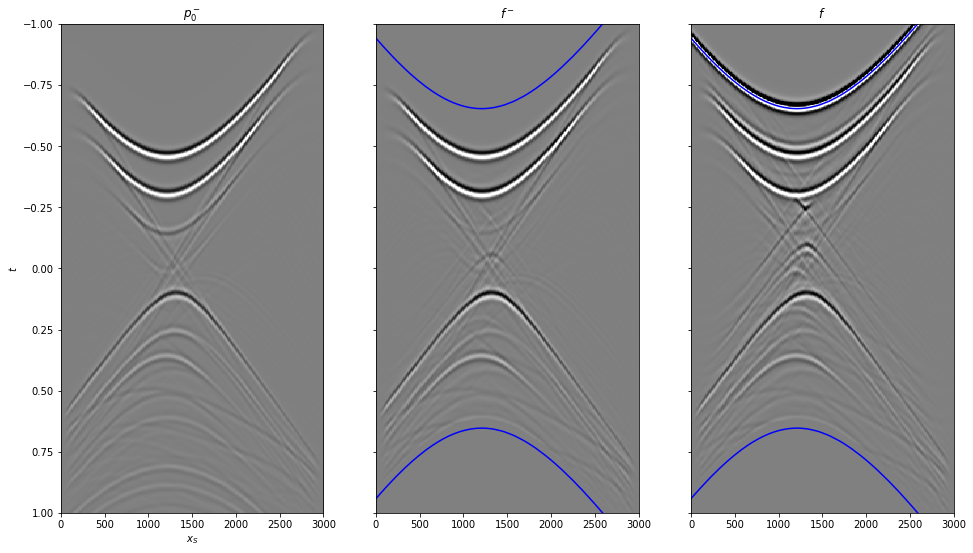

In [14]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_minus.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_S$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_minus.T + f1_inv_plus.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$'), axs[0].set_xlabel(r'$x_S$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

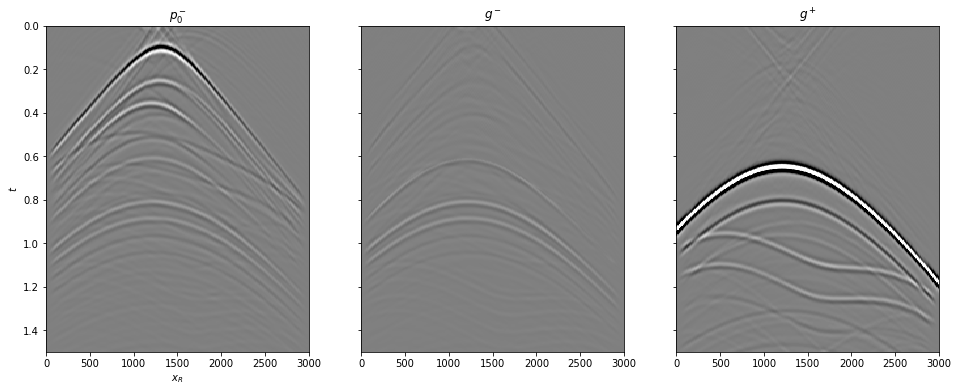

In [15]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0);
axs[1].imshow(g_inv_minus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);
axs[2].imshow(g_inv_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0);

## Marchenko with missing sources

Let's consider the case of missing sources. We will restrict $R$ and at the same time replace the Identity operator with a Restriction operator along the main diagonal of the Marchenko operator.

$$
\begin{bmatrix}
   \Theta \mathbf{R_S} \mathbf{f_d^+}  \\
   \mathbf{0}
\end{bmatrix} =
\begin{bmatrix}
   \mathbf{S}  &   \Theta \mathbf{R_S}   \\
   \Theta \mathbf{R_S^*} & \mathbf{S}
\end{bmatrix}
\begin{bmatrix}
   \mathbf{f^-}  \\
   \mathbf{f_m^+}
\end{bmatrix}
$$
where $\mathbf{R_S}$ is a restricted reflection response (i.e., only with available sources)
To be able to deal with missing sources (and gaps in the retrieved focusing functions) we will use a sliding linear Radon sparsity transform and L1 solver FISTA.

In [16]:
# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((ns, nr, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, s, r]

# subsampling
iava = np.loadtxt(path0 + 'temp_select_rfrac70.dat', delimiter=',', dtype=int) - 1
nsava = iava.shape[0]
Rtwosided_fft = Rtwosided_fft[:, iava]
Restrop = Restriction(ns*(2*nt-1), iava, dims=(2*nt-1, ns), dir=1, dtype='float64')

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, transpose=False, dtype='complex64')
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, transpose=False, conj=True, dtype='complex64')
Rollop = Roll((2*nt-1) * nsava,
              dims=(2*nt-1, nsava),
              dir=0, shift=-1)
Restrop = Restriction(ns*(2*nt-1), iava, dims=(2*nt-1, ns), dir=1, dtype='float64')
Wsop = Diagonal(w[iava].T.flatten())
Wrop = Diagonal(w.T.flatten())

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr))))

Create Marchenko operator

In [17]:
Mop = VStack([HStack([Restrop, -1*Wsop*Rop]),
              HStack([-1*Wsop*Rollop*R1op, Restrop])])*BlockDiag([Wrop, Wrop])
Gop = VStack([HStack([Restrop, -1*Rop]),
              HStack([-1*Rollop*R1op, Restrop])])

dottest(Gop, 2*nsava*(2*nt-1), 2*nr*(2*nt-1), verb=True)
dottest(Mop, 2*nsava*(2*nt-1), 2*nr*(2*nt-1), verb=True);

Dot test passed, v^T(Opu)=-715.036171 - u^T(Op^Tv)=-715.036171
Dot test passed, v^T(Opu)=-43.615391 - u^T(Op^Tv)=-43.615391


Run standard redatuming as benchmark

In [18]:
p0_minus_sub = Rop * fd_plus.flatten()
p0_minus_sub = p0_minus_sub.reshape((2*nt-1), nsava).T

Create data, adjoint and inverse focusing functions

In [19]:
d_sub = Wsop*Rop*fd_plus.flatten()
d_sub = np.concatenate((d_sub.reshape(2*nt-1, nsava), np.zeros((2*nt-1, nsava))))

f1_adj_sub = Mop.H*d_sub.flatten()
f1_inv_sub = lsqr(Mop, d_sub.flatten(), iter_lim=n_iter, show=True)[0]

f1_adj_sub = f1_adj_sub.reshape(2*nt2, nr)
f1_inv_sub = f1_inv_sub.reshape(2*nt2, nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   609402 rows  and   868722 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.469e+01  4.469e+01    1.0e+00  2.3e-02
     1  0.00000e+00   1.677e+01  1.677e+01    3.8e-01  1.0e+00   1.1e+00  1.0e+00
     2  0.00000e+00   8.622e+00  8.622e+00    1.9e-01  4.8e-01   1.8e+00  2.2e+00
     3  0.00000e+00   5.970e+00  5.970e+00    1.3e-01  3.6e-01   2.2e+00  3.4e+00
     4  0.00000e+00   3.917e+00  3.917e+00    8.8e-02  3.3e-01   2.6e+00  4.9e+00
     5  0.00000e+00   2.661e+00  2.661e+00    6.0e-02  2.5e-01   2.9e+00  6.5e+00
     6  0.00000e+00   1.991e+00  1.991e+00    4.5e-02  2.3e-01   3.2e+00  8.0e+00
     7  0.00000e+00   1.391e+00  1.391e+00    3.1e-02  2.2e-01   3.5e+00  9.8e+00
     8  0.00000e+00   1.019e

Add initial guess to estimated focusing functions

In [20]:
f1_adj_sub_tot = f1_adj_sub + np.concatenate((np.zeros((2*nt-1, nr)),
                                      np.concatenate((np.fliplr(G0sub.T).T, 
                                                      np.zeros((nt-1, nr))), axis=0)))

f1_inv_sub_tot = f1_inv_sub + np.concatenate((np.zeros((2*nt-1, nr)), fd_plus))

Estimate Green's functions

In [21]:
g_adj_sub = Gop*f1_adj_sub_tot.flatten()
g_inv_sub = Gop*f1_inv_sub_tot.flatten()

g_adj_sub = g_adj_sub.reshape(2*(2*nt-1), nsava)
g_inv_sub = g_inv_sub.reshape(2*(2*nt-1), nsava)

Extract up and down focusing and Green's functions from model vectors

In [22]:
f1_adj_sub_minus, f1_adj_sub_plus =  f1_adj_sub_tot[:(2*nt-1)].T, f1_adj_sub_tot[(2*nt-1):].T
f1_inv_sub_minus, f1_inv_sub_plus =  f1_inv_sub_tot[:(2*nt-1)].T, f1_inv_sub_tot[(2*nt-1):].T

g_adj_sub_minus, g_adj_sub_plus =  -g_adj_sub[:(2*nt-1)].T, np.fliplr(g_adj_sub[(2*nt-1):].T)
g_inv_sub_minus, g_inv_sub_plus =  -g_inv_sub[:(2*nt-1)].T, np.fliplr(g_inv_sub[(2*nt-1):].T)

g_inv_sub_tot = g_inv_sub_minus + g_inv_sub_plus

Visualization

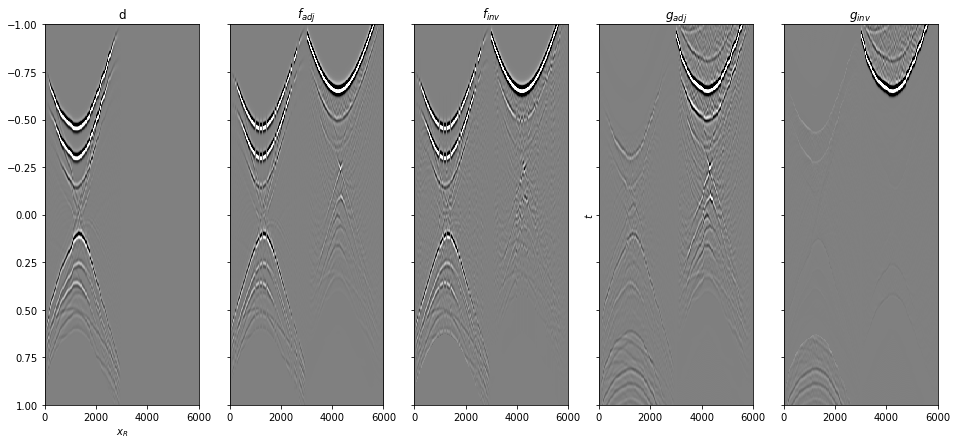

In [23]:
# Need to recreate combined data as new implementation stacks over time instead of space
d_sub_plot = np.concatenate((d_sub[:(2*nt-1)], d_sub[(2*nt-1):]), axis=1).T
f1_adj_sub_tot_plot = np.concatenate((f1_adj_sub_tot[:(2*nt-1)], f1_adj_sub_tot[(2*nt-1):]), axis=1).T
f1_inv_sub_tot_plot = np.concatenate((f1_inv_sub_tot[:(2*nt-1)], f1_inv_sub_tot[(2*nt-1):]), axis=1).T
g_adj_sub_plot = np.concatenate((g_adj_sub[:(2*nt-1)], g_adj_sub[(2*nt-1):]), axis=1).T
g_inv_sub_plot = np.concatenate((g_inv_sub[:(2*nt-1)], g_inv_sub[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d_sub_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_S$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_adj_sub_tot_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_sub_tot_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(g_adj_sub_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(g_inv_sub_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

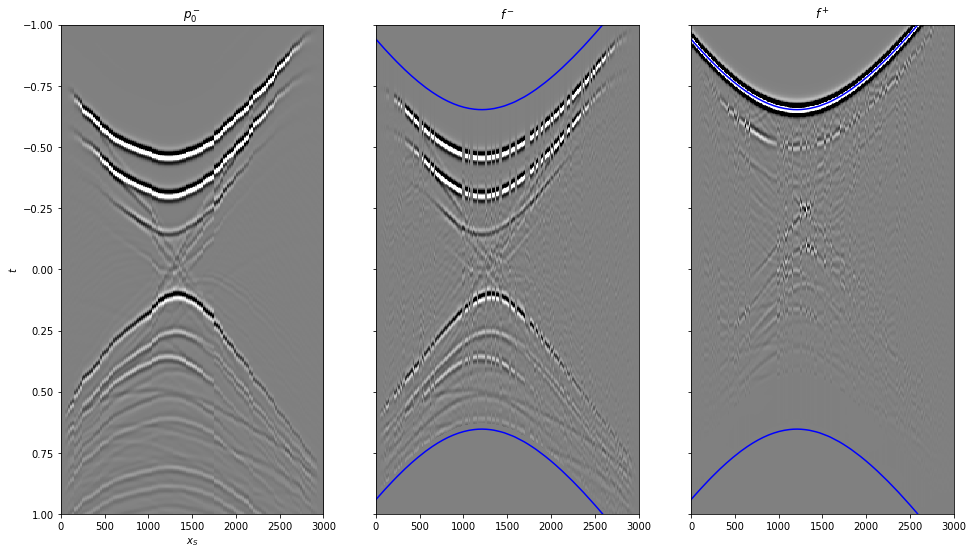

In [24]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus_sub.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_sub_minus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_S$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_sub_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_S$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

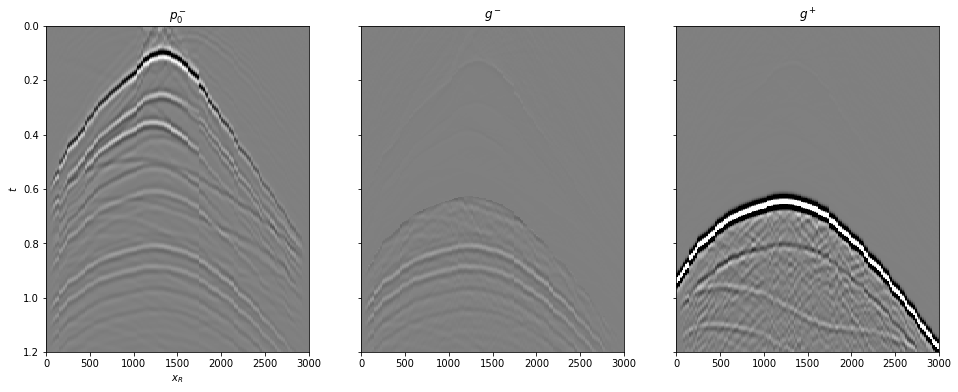

In [25]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
axs[0].imshow(p0_minus_sub.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.2, 0);
axs[1].imshow(g_inv_sub_minus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.2, 0);
axs[2].imshow(g_inv_sub_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.2, 0);

## Marchenko with missing sources and Radon sparsity transform

We try now to express the focusing functions as local linear events in an attempt to fill the gaps

$$
\begin{bmatrix}
   \Theta \mathbf{R_S} \mathbf{f_d^+}  \\
   \mathbf{0}
\end{bmatrix} =
\begin{bmatrix}
   \mathbf{S}  &   \Theta \mathbf{R_S}   \\
   \Theta \mathbf{R_S^*} & \mathbf{S}
\end{bmatrix}
\begin{bmatrix}
   \mathbf{F}^H  & \mathbf{0}   \\
   \mathbf{0} & \mathbf{F}^H
\end{bmatrix}
\begin{bmatrix}
   \mathbf{f^-}  \\
   \mathbf{f_m^+}
\end{bmatrix}
$$

In [26]:
nwin=35
nwins=7
nover=10
npx=101
pxmax = 1e-3
px = np.linspace(-pxmax, pxmax, npx)
dimsd = (nr, nt2) 
dimss = (nwins*npx, dimsd[1])

# tranpose operator
Top = Transpose((nt2, nr), axes=(1, 0), dtype=np.float64)

# sliding window radon with overlap
RadOp = Radon2D(t2, np.linspace(-dr*nwin//2, dr*nwin//2, nwin), px, centeredh=True,
                kind='linear', engine='numba')
Slidop = Sliding2D(RadOp, dimss, dimsd, nwin, nover, tapertype='cosine', design=False)
dottest(Slidop, np.prod(dimsd), np.prod(dimss), verb=True);

Sparseop = BlockDiag([Top.H*Slidop, Top.H*Slidop])
Mop_radon = Mop * Sparseop
dottest(Mop_radon, 2*nsava*(2*nt-1), 2*np.prod(dimss), verb=True);

Dot test passed, v^T(Opu)=-13621.657694 - u^T(Op^Tv)=-13621.657694
Dot test passed, v^T(Opu)=803.800234 - u^T(Op^Tv)=803.800234


Forward and adjoint Radon

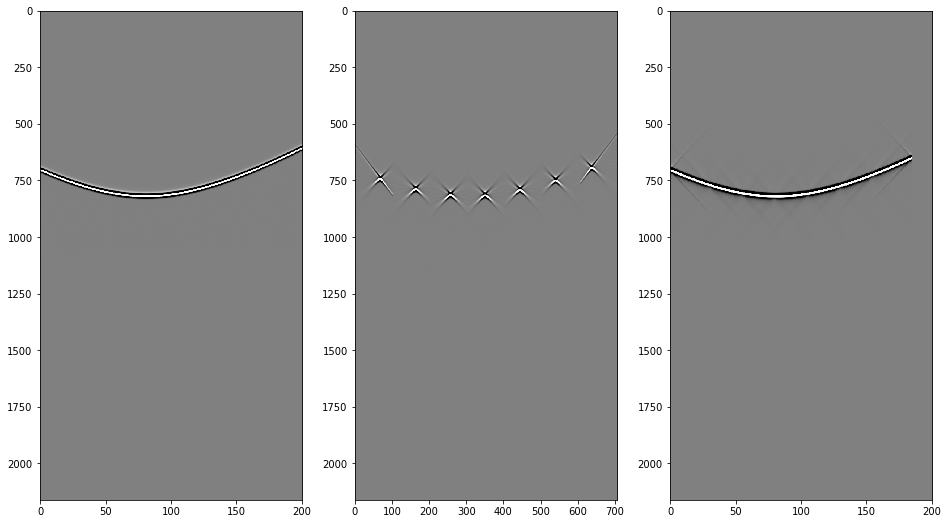

In [27]:
fd_plus1 = np.concatenate([fd_plus, fd_plus])
fd_plus1_radon = Sparseop.H*fd_plus1.flatten()
fd_plus2_radon = Sparseop * fd_plus1_radon

fd_plus1_radon = fd_plus1_radon.reshape(2*npx*nwins, nt2)
fd_plus2_radon = fd_plus2_radon.reshape(2*nt2, nr)

fig, axs = plt.subplots(1, 3, figsize=(16, 9))
axs[0].imshow(fd_plus1[:nt2], cmap='gray', vmin=-5e-1, vmax=5e-1)
axs[0].axis('tight')
axs[1].imshow(fd_plus1_radon[:npx*nwins].T, cmap='gray', vmin=-5e0, vmax=5e0)
axs[1].axis('tight');
axs[2].imshow(fd_plus2_radon[:nt2], cmap='gray', vmin=-5e1, vmax=5e1)
axs[2].axis('tight');

And on one of the previously found solutions (upgoing focusing function)

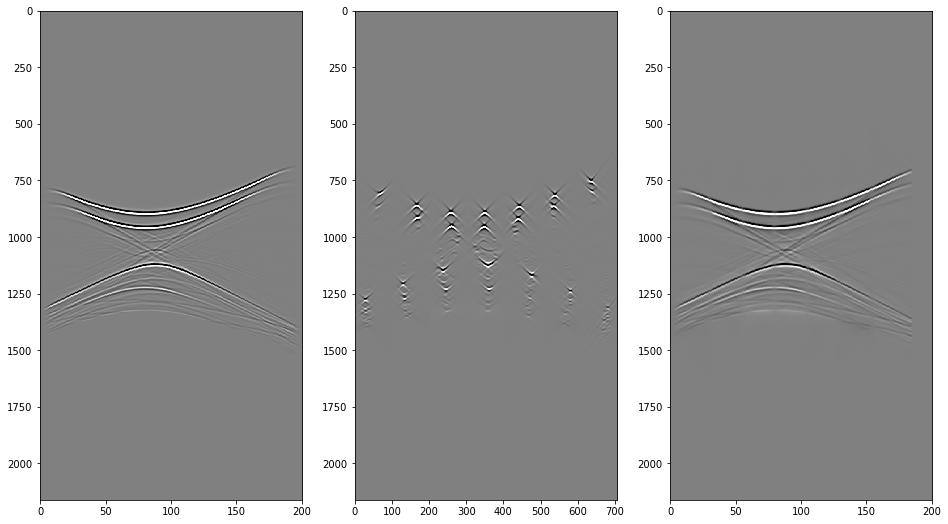

In [28]:
f1_minus_radon = Slidop.H * f1_inv_minus.flatten()
f1_minus_rec = Slidop * f1_minus_radon
f1_minus_radon = f1_minus_radon.reshape(npx*nwins, nt2)
f1_minus_rec = f1_minus_rec.reshape(nr, nt2)

fig, axs = plt.subplots(1, 3, figsize=(16, 9))
axs[0].imshow(f1_inv_minus.T, cmap='gray', vmin=-5e-1, vmax=5e-1)
axs[0].axis('tight')
axs[1].imshow(f1_minus_radon.T, cmap='gray', vmin=-5e0, vmax=5e0)
axs[1].axis('tight')
axs[2].imshow(f1_minus_rec.T, cmap='gray', vmin=-1e2, vmax=1e2)
axs[2].axis('tight');

L2 Inversion

In [29]:
f1_radon_inv = lsqr(Mop_radon, d_sub.flatten(), iter_lim=n_iter, show=True)[0]
f1_radon_inv = Sparseop * f1_radon_inv

f1_radon_inv = f1_radon_inv.reshape(2*nt2, nr)
f1_radon_inv = f1_radon_inv.reshape(2*nt2, nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   609402 rows  and 3.05565e+06 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.469e+01  4.469e+01    1.0e+00  2.6e-01
     1  0.00000e+00   2.389e+01  2.389e+01    5.3e-01  1.0e+00   1.4e+01  1.0e+00
     2  0.00000e+00   1.807e+01  1.807e+01    4.0e-01  5.8e-01   2.7e+01  2.5e+00
     3  0.00000e+00   1.435e+01  1.435e+01    3.2e-01  3.4e-01   4.1e+01  4.4e+00
     4  0.00000e+00   1.204e+01  1.204e+01    2.7e-01  2.5e-01   5.2e+01  6.3e+00
     5  0.00000e+00   1.010e+01  1.010e+01    2.3e-01  2.0e-01   6.1e+01  8.2e+00
     6  0.00000e+00   8.825e+00  8.825e+00    2.0e-01  1.7e-01   6.8e+01  1.0e+01
     7  0.00000e+00   7.799e+00  7.799e+00    1.7e-01  1.5e-01   7.6e+01  1.2e+01
     8  0.00000e+00   6.9

In [30]:
f1_radon_inv_tot = f1_radon_inv + np.concatenate((np.zeros((nt2, nr)), fd_plus))

g_radon_inv = Gop*f1_radon_inv_tot.flatten()
g_radon_inv = g_radon_inv.reshape(2*(2*nt-1), nsava)

f1_radon_inv_minus, f1_radon_inv_plus =  f1_radon_inv_tot[:(2*nt-1)].T, f1_radon_inv_tot[(2*nt-1):].T
g_radon_inv_minus, g_radon_inv_plus =  -g_radon_inv[:(2*nt-1)].T, np.fliplr(g_radon_inv[(2*nt-1):].T)

g_radon_inv_tot = g_radon_inv_minus + g_radon_inv_plus

Sparse inversion

In [31]:
f1_radon_l1 = FISTA(Mop_radon, d_sub.flatten(), eps=1e-2, niter=n_iter*2, 
                    alpha = 4.936579e-04, #eigsiter=4, eigstol=1e-3, 
                    tol=1e-2, returninfo=False, show=True)[0]
f1_radon_l1 = Sparseop * f1_radon_l1
f1_radon_l1 = f1_radon_l1.reshape(2*nt2, nr)

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 609402 rows and 3055654 cols
eps = 1.000000e-02	tol = 1.000000e-02	niter = 400
alpha = 4.936579e-04	thresh = 2.468289e-06
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   8.746e+02   8.753e+02   2.529e-01
     2   0.00000e+00   7.713e+02   7.726e+02   2.304e-01
     3   0.00000e+00   6.610e+02   6.630e+02   2.708e-01
     4   0.00000e+00   5.523e+02   5.551e+02   2.985e-01
     5   0.00000e+00   4.514e+02   4.551e+02   3.152e-01
     6   0.00000e+00   3.621e+02   3.666e+02   3.224e-01
     7   0.00000e+00   2.859e+02   2.912e+02   3.217e-01
     8   0.00000e+00   2.231e+02   2.292e+02   3.145e-01
     9   0.00000e+00   1.728e+02   1.797e+02   3.024e-01
    10   0.00000e+00   1.336e+02   1.412e+02   2.866e-01
    11   0.00000e+00   1.037e+02   1.120e+02   2.685e-01
    21   0.0000

In [32]:
f1_radon_l1_tot = f1_radon_l1 + np.concatenate((np.zeros((nt2, nr)), fd_plus))

g_radon_l1 = Gop*f1_radon_l1_tot.flatten()
g_radon_l1 = g_radon_l1.reshape(2*(2*nt-1), nsava)

f1_radon_l1_minus, f1_radon_l1_plus =  f1_radon_l1_tot[:(2*nt-1)].T, f1_radon_l1_tot[(2*nt-1):].T
g_radon_l1_minus, g_radon_l1_plus =  -g_radon_l1[:(2*nt-1)].T, np.fliplr(g_radon_l1[(2*nt-1):].T)

g_radon_l1_tot = g_radon_l1_minus + g_radon_l1_plus

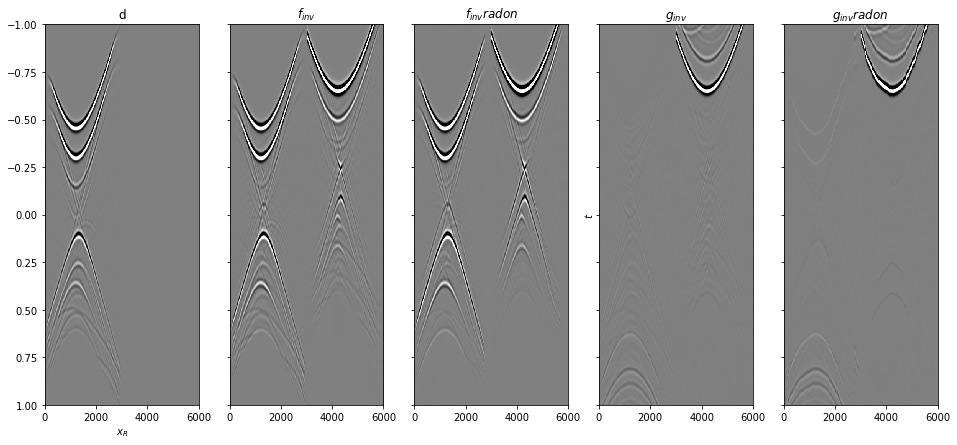

In [33]:
# Need to recreate combined data as new implementation stacks over time instead of space
f1_radon_l1_tot_plot = np.concatenate((f1_radon_l1_tot[:(2*nt-1)], f1_radon_l1_tot[(2*nt-1):]), axis=1).T
g_radon_l1_plot = np.concatenate((g_radon_l1[:(2*nt-1)], g_radon_l1[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_inv_tot_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_radon_l1_tot_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv} radon$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(g_inv_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(g_radon_l1_plot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv} radon$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

Compare with benchmark focusing functions (from regularly sampled data)

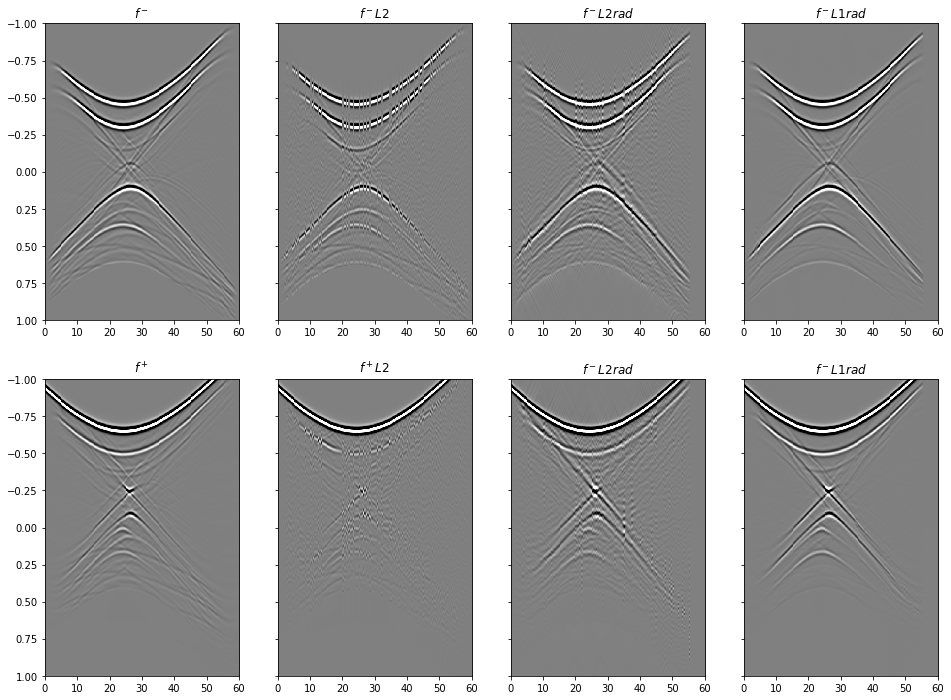

In [34]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(16, 12))
axs[0][0].imshow(f1_inv_minus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0][0].set_title(r'$f^-$')
axs[0][0].axis('tight')
axs[0][0].set_ylim(1, -1);
axs[0][1].imshow(f1_inv_sub_minus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0][1].set_title(r'$f^- L2$')
axs[0][1].axis('tight')
axs[0][1].set_ylim(1, -1)
axs[0][2].imshow(f1_radon_inv_minus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0][2].set_title(r'$f^- L2rad$')
axs[0][2].axis('tight')
axs[0][2].set_ylim(1, -1)
axs[0][3].imshow(f1_radon_l1_minus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0][3].set_title(r'$f^- L1rad$')
axs[0][3].axis('tight')
axs[0][3].set_ylim(1, -1)
axs[1][0].imshow(f1_inv_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1][0].set_title(r'$f^+$')
axs[1][0].axis('tight')
axs[1][0].set_ylim(1, -1);
axs[1][1].imshow(f1_inv_sub_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1][1].set_title(r'$f^+ L2$')
axs[1][1].axis('tight')
axs[1][1].set_ylim(1, -1);
axs[1][2].imshow(f1_radon_inv_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1][2].set_title(r'$f^- L2rad$')
axs[1][2].axis('tight')
axs[1][2].set_ylim(1, -1);
axs[1][3].imshow(f1_radon_l1_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1][3].set_title(r'$f^- L1rad$')
axs[1][3].axis('tight')
axs[1][3].set_ylim(1, -1);

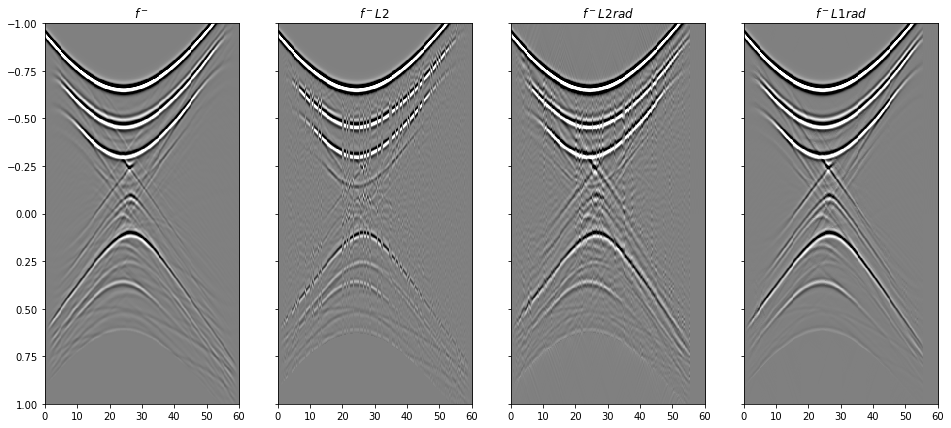

In [35]:
clip = 7e-1

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(16, 7))
axs[0].imshow(f1_inv_minus.T + f1_inv_plus.T, cmap='gray', vmin=-clip, vmax=clip, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0].set_title(r'$f^-$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_sub_minus.T + f1_inv_sub_plus.T, cmap='gray', vmin=-clip, vmax=clip, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1].set_title(r'$f^- L2$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1)
axs[2].imshow(f1_radon_inv_minus.T + f1_radon_inv_plus.T, cmap='gray', vmin=-clip, vmax=clip, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[2].set_title(r'$f^- L2rad$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)
axs[3].imshow(f1_radon_l1_minus.T + f1_radon_l1_plus.T, cmap='gray', vmin=-clip, vmax=clip, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[3].set_title(r'$f^- L1rad$')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);

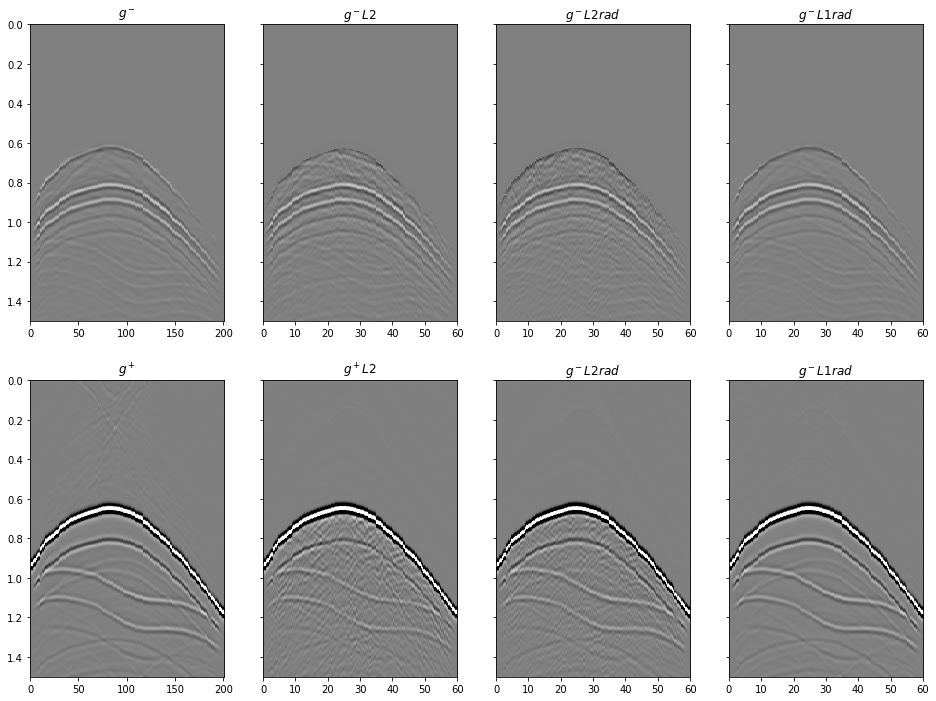

In [36]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(16, 12))
axs[0][0].imshow((1-w[iava].T)*g_inv_minus[iava].T, cmap='gray', vmin=-2e-1, vmax=2e-1, 
                 extent=(0, ns, t[-1], -t[-1]))
axs[0][0].set_title(r'$g^-$')
axs[0][0].axis('tight')
axs[0][1].imshow((1-w[iava].T)*g_inv_sub_minus.T, cmap='gray', vmin=-2e-1, vmax=2e-1, 
                 extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0][1].set_title(r'$g^- L2$')
axs[0][1].axis('tight')
axs[0][2].imshow((1-w[iava].T)*g_radon_inv_minus.T, cmap='gray', vmin=-2e-1, vmax=2e-1, 
                 extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0][2].set_title(r'$g^- L2rad$')
axs[0][2].axis('tight')
axs[0][2].set_ylim(1.5, 0)
axs[0][3].imshow((1-w[iava].T)*g_radon_l1_minus.T, cmap='gray', vmin=-2e-1, vmax=2e-1, 
                 extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0][3].set_title(r'$g^- L1rad$')
axs[0][3].axis('tight')
axs[0][3].set_ylim(1.5, 0)
axs[1][0].imshow(g_inv_plus[iava].T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
                 extent=(0, ns, t[-1], -t[-1]))
axs[1][0].set_title(r'$g^+$')
axs[1][0].axis('tight')
axs[1][1].imshow(g_inv_sub_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
                 extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1][1].set_title(r'$g^+ L2$')
axs[1][1].axis('tight')
axs[1][2].imshow(g_radon_inv_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
                 extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1][2].set_title(r'$g^- L2rad$')
axs[1][2].axis('tight')
axs[1][2].set_ylim(1.5, 0);
axs[1][3].imshow(g_radon_l1_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
                 extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1][3].set_title(r'$g^- L1rad$')
axs[1][3].axis('tight')
axs[1][3].set_ylim(1.5, 0);

And in the Radon domain

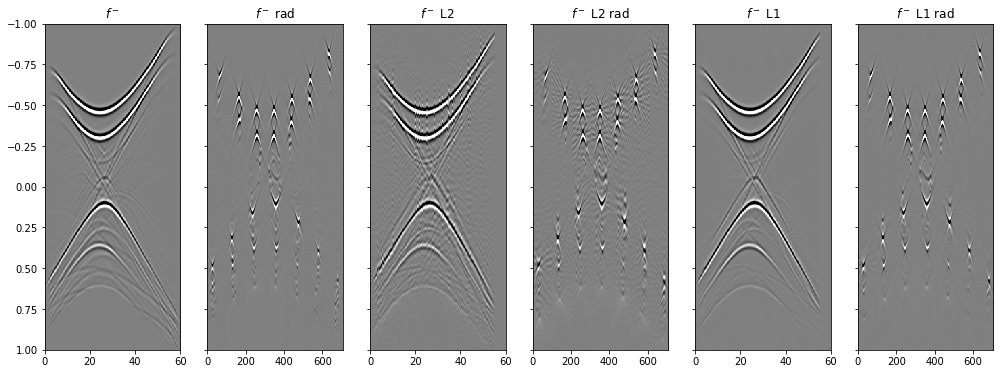

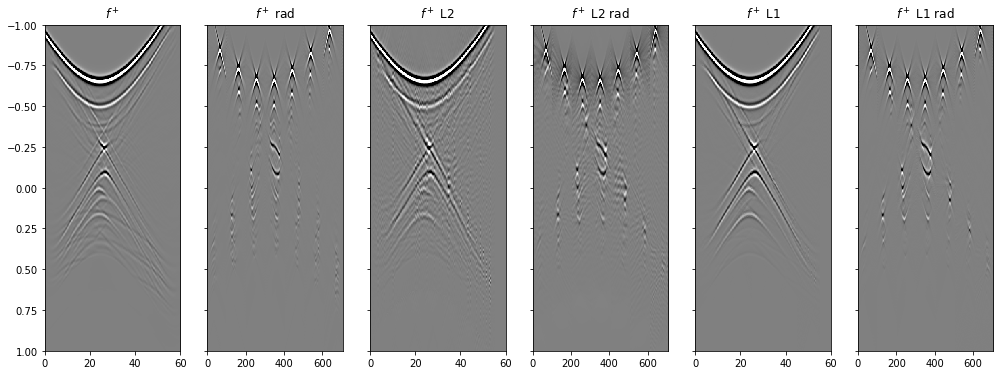

In [37]:
f1_inv_minus_radon = Slidop.H * f1_inv_minus.flatten()
f1_inv_minus_radon = f1_inv_minus_radon.reshape(npx*nwins, nt2)

f1_radon_inv_minus_radon = Slidop.H * f1_radon_inv_minus.flatten()
f1_radon_inv_minus_radon = f1_radon_inv_minus_radon.reshape(npx*nwins, nt2)

f1_radon_l1_minus_radon = Slidop.H * f1_radon_l1_minus.flatten()
f1_radon_l1_minus_radon = f1_radon_l1_minus_radon.reshape(npx*nwins, nt2)

f1_inv_plus_radon = Slidop.H * f1_inv_plus.flatten()
f1_inv_plus_radon = f1_inv_plus_radon.reshape(npx*nwins, nt2)

f1_radon_inv_plus_radon = Slidop.H * f1_radon_inv_plus.flatten()
f1_radon_inv_plus_radon = f1_radon_inv_plus_radon.reshape(npx*nwins, nt2)

f1_radon_l1_plus_radon = Slidop.H * f1_radon_l1_plus.flatten()
f1_radon_l1_plus_radon = f1_radon_l1_plus_radon.reshape(npx*nwins, nt2)


fig, axs = plt.subplots(1, 6, sharey=True, figsize=(17, 6))
axs[0].imshow(f1_inv_minus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0].set_title(r'$f^-$')
axs[0].axis('tight')
axs[1].imshow(f1_inv_minus_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ rad')
axs[1].axis('tight');
axs[2].imshow(f1_radon_inv_minus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[2].axis('tight')
axs[2].set_title(r'$f^-$ L2')
axs[3].imshow(f1_radon_inv_minus_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[3].axis('tight')
axs[3].set_title(r'$f^-$ L2 rad')
axs[3].set_ylim(1, -1);
axs[4].imshow(f1_radon_l1_minus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[4].axis('tight')
axs[4].set_title(r'$f^-$ L1')
axs[5].imshow(f1_radon_l1_minus_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[5].axis('tight')
axs[5].set_title(r'$f^-$ L1 rad')
axs[5].set_ylim(1, -1);

fig, axs = plt.subplots(1, 6, sharey=True, figsize=(17, 6))
axs[0].imshow(f1_inv_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0].set_title(r'$f^+$')
axs[0].axis('tight')
axs[1].imshow(f1_inv_plus_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[1].set_title(r'$f^+$ rad')
axs[1].axis('tight');
axs[2].imshow(f1_radon_inv_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[2].set_title(r'$f^+$ L2')
axs[2].axis('tight')
axs[3].imshow(f1_radon_inv_plus_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[3].axis('tight')
axs[3].set_title(r'$f^+$ L2 rad')
axs[3].set_ylim(1, -1);
axs[4].imshow(f1_radon_l1_plus.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[4].set_title(r'$f^+$ L1')
axs[4].axis('tight')
axs[5].imshow(f1_radon_l1_plus_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[5].axis('tight')
axs[5].set_title(r'$f^+$ L1 rad')
axs[5].set_ylim(1, -1);

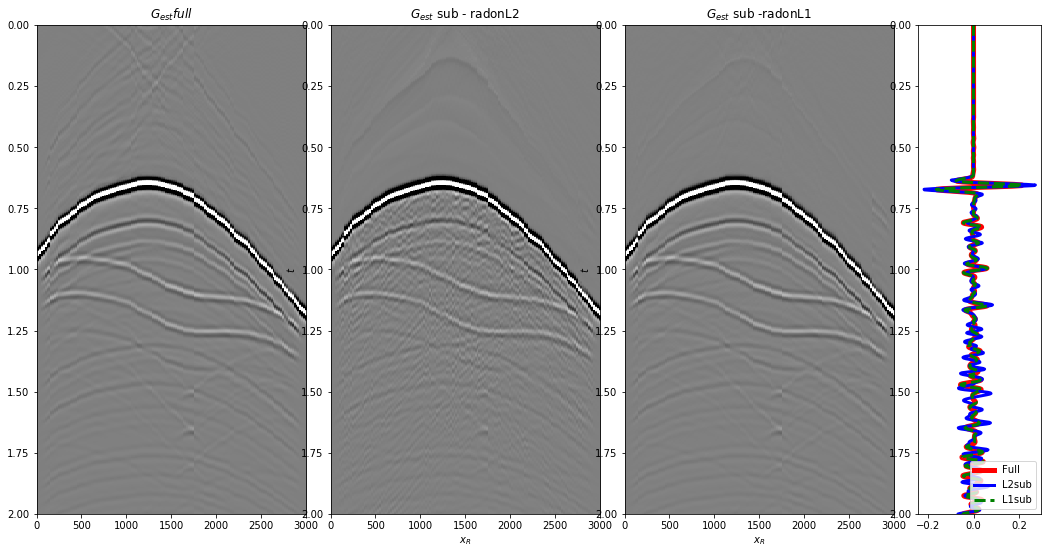

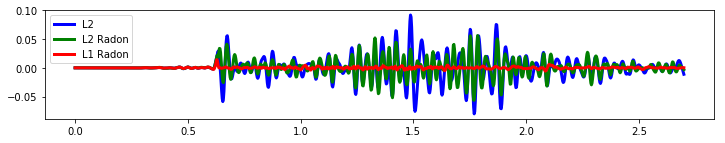

In [45]:
fig = plt.figure(figsize=(18,9))
ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 7), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 7), (0, 4), colspan=2)
ax4 = plt.subplot2grid((1, 7), (0, 6))

ax1.imshow(g_inv_tot[iava].T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax1.set_title(r'$G_{est} full $'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(2, 0)
ax2.imshow(g_radon_inv_tot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$ sub - radonL2'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(2, 0)
ax3.imshow(g_radon_l1_tot.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax3.set_title(r'$G_{est}$ sub -radonL1'), ax3.set_xlabel(r'$x_R$'), ax3.set_ylabel(r'$t$')
ax3.axis('tight')
ax3.set_ylim(2, 0)
ax4.plot(t**3*g_inv_tot[iava][nr//4, nt-1:]/g_inv_tot.max(), t, 'r', lw=5, label='Full')
ax4.plot(t**3*g_inv_sub_tot[nr//4, nt-1:]/g_inv_tot.max(), t, 'b', lw=3, label='L2sub')
ax4.plot(t**3*g_radon_l1_tot[nr//4, nt-1:]/g_inv_tot.max(), t, '--g', lw=3, label='L1sub')
ax4.set_ylim(2, 0);
ax4.legend();

plt.figure(figsize=(12, 2))
plt.plot(t, t**3*g_inv_tot[iava][nr//4, nt-1:]/g_inv_tot.max() - t**3*g_inv_sub_tot[nr//4, nt-1:]/g_inv_tot.max(), 
         'b', lw=3, label='L2')
plt.plot(t, t**3*g_inv_tot[iava][nr//4, nt-1:]/g_inv_tot.max() - t**3*g_radon_inv_tot[nr//4, nt-1:]/g_inv_tot.max(), 
         'g', lw=3, label='L2 Radon')
plt.plot(t, t**3*g_inv_tot[iava][nr//4, nt-1:]/g_inv_tot.max() - t**3*g_radon_l1_tot[nr//4, nt-1:]/g_inv_tot.max(), 
         'r', lw=3, label='L1 Radon')
plt.legend();